# Tree segmentation with multitemporal Sentinel 1/2 imagery

## John Brandt
## December 2023

## This notebook finetunes the TTC decoder for a new task

## Package Loading

In [1]:
from tqdm import tqdm_notebook, tnrange
import tensorflow.compat.v1 as tf
if tf.__version__[0] == '2':
    
    tf.disable_v2_behavior()
    #tf.enable_eager_execution()
    sess = tf.Session()
else:
    from keras import backend as K
    sess = tf.Session()
    K.set_session(sess)

from time import sleep

import keras
#from tf.python.keras.layers import *

if tf.__version__[0] == '2':
    from tensorflow.compat.v1.layers import *
    from tensorflow.compat.v1.initializers import glorot_normal, lecun_normal
else:
    from tensorflow.python.keras.layers import *
    from tensorflow.initializers import glorot_normal, lecun_normal
    
from scipy.ndimage import median_filter
from skimage.transform import resize

import pandas as pd
import numpy as np
from random import shuffle
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os
import random
import itertools
from tensorflow.python.util import deprecation as deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

os.environ['KMP_DUPLICATE_LIB_OK']='True'

Instructions for updating:
non-resource variables are not supported in the long term


2024-01-04 11:44:10.612208: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2024-01-04 11:44:10.612224: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2024-01-04 11:44:10.612231: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2024-01-04 11:44:10.612258: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-04 11:44:10.612277: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Utility scripts

In [2]:
%run ../src/layers/zoneout.py
%run ../src/layers/losses.py
%run ../src/layers/adabound.py
%run ../src/layers/convgru.py
%run ../src/layers/dropblock.py
%run ../src/layers/extra_layers.py
%run ../src/layers/stochastic_weight_averaging.py
%run ../src/preprocessing/indices.py
%run ../src/preprocessing/slope.py

# Hyperparameter definitions

In [3]:
ZONE_OUT_PROB = 0.90
ACTIVATION_FUNCTION = 'swish'

INITIAL_LR = 1e-3
DROPBLOCK_MAXSIZE = 5

N_CONV_BLOCKS = 1
FINAL_ALPHA = 0.33
LABEL_SMOOTHING = 0.03

L2_REG = 0.
BATCH_SIZE = 32
MAX_DROPBLOCK = 0.6

FRESH_START = True
best_val = 0.2

START_EPOCH = 1
END_EPOCH = 100

n_bands = 17
initial_flt = 32
mid_flt = 32 * 2
high_flt = 32 * 2 * 2

temporal_model = True
input_size = 124
output_size = 14

# Custom layer definitions

### Conv GRU Block

In [4]:
def gru_block(inp, length, size, flt, scope, train, normalize = True):
    '''Bidirectional convolutional GRU block with 
       zoneout and CSSE blocks in each time step

         Parameters:
          inp (tf.Variable): (B, T, H, W, C) layer
          length (tf.Variable): (B, T) layer denoting number of
                                steps per sample
          size (int): kernel size of convolution
          flt (int): number of convolution filters
          scope (str): tensorflow variable scope
          train (tf.Bool): flag to differentiate between train/test ops
          normalize (bool): whether to compute layer normalization

         Returns:
          gru (tf.Variable): (B, H, W, flt*2) bi-gru output
          steps (tf.Variable): (B, T, H, W, flt*2) output of each step
    '''
    with tf.variable_scope(scope):
        print(f"GRU input shape {inp.shape}, zoneout: {ZONE_OUT_PROB}")
        
        # normalize is internal group normalization within the reset gate
        # sse is internal SSE block within the state cell

        cell_fw = ConvGRUCell(shape = size, filters = flt,
                           kernel = [3, 3], padding = 'VALID', 
                           normalize = normalize, sse = True)
        cell_bw = ConvGRUCell(shape = size, filters = flt,
                           kernel = [3, 3], padding = 'VALID',
                           normalize = normalize, sse = True)
        
        cell_fw = ZoneoutWrapper(
           cell_fw, zoneout_drop_prob = 0.75, is_training = train)
        cell_bw = ZoneoutWrapper(
            cell_bw, zoneout_drop_prob = 0.75, is_training = train)
        steps, out = convGRU(inp, cell_fw, cell_bw, length)
        gru = tf.concat(out, axis = -1)
        steps = tf.concat(steps, axis = -1)
        print(f"GRU block output shape {gru.shape}")
    return gru, steps

# Model definition

## Placeholders

In [5]:
#reg = tf.contrib.layers.l2_regularizer(0.)
temporal_model = True
n_bands = 17
output_size = input_size - 14

if temporal_model:
    inp = tf.placeholder(tf.float32, shape=(None, 5, input_size, input_size, n_bands))
    length = tf.placeholder_with_default(np.full((1,), 4), shape = (None,))
else:
    inp = tf.placeholder(tf.float32, shape=(None, input_size, input_size, n_bands))
    
labels = tf.placeholder(tf.float32, shape=(None, output_size, output_size))#, 1))
mask = tf.placeholder(tf.float32, shape = (None, output_size, output_size))
keep_rate = tf.placeholder_with_default(1.0, ()) # For DropBlock
is_training = tf.placeholder_with_default(False, (), 'is_training') # For DropBlock
alpha = tf.placeholder(tf.float32, shape = ()) # For loss scheduling
ft_lr = tf.placeholder_with_default(0.001, shape = ()) # For loss scheduling
loss_weight = tf.placeholder_with_default(1.0, shape = ())
beta_ = tf.placeholder_with_default(0.0, shape = ()) # For loss scheduling, not currently implemented

## Layers

In [6]:
# master modmel is 32, 64, 96, 230k paramms
initial_flt = 64
mid_flt = initial_flt * 2
high_flt = initial_flt * 2 * 2

gru_input = inp[:, :-1, ...]
gru, steps = gru_block(inp = gru_input, length = length,
                            size = [input_size, input_size, ], # + 2 here for refleclt pad
                            flt = initial_flt // 2,
                            scope = 'down_16',
                            train = is_training)
with tf.variable_scope("gru_drop"):
    drop_block = DropblockV2(gru, tf.shape(gru),keep_rate,4)
    gru = drop_block(gru, is_training)
    
# Median conv
median_input = inp[:, -1, ...]
median_conv = conv_swish_gn(inp = median_input, is_training = is_training, stride = (1, 1),
            kernel_size = 3, scope = 'conv_median', filters = initial_flt, 
            keep_rate = keep_rate, activation = True, use_bias = False, norm = True,
            csse = True, dropblock = True, weight_decay = None,
                            window_size = 104)
print(f"Median conv: {median_conv.shape}")

concat1 = tf.concat([gru, median_conv], axis = -1)


concat = conv_swish_gn(inp = concat1, is_training = is_training, stride = (1, 1),
            kernel_size = 3, scope = 'conv_concat', filters = initial_flt,
            keep_rate = keep_rate, activation = True, use_bias = False, norm = True,
            csse = True, dropblock = True, weight_decay = None, padding = "SAME",
                       window_size = 104)
print(f"Concat: {concat.shape}")

# MaxPool-conv-swish-GroupNorm-csse
pool1 = MaxPool2D()(concat)
conv1 = conv_swish_gn(inp = pool1, is_training = is_training, stride = (1, 1),
            kernel_size = 3, scope = 'conv1', filters = mid_flt,
            keep_rate = keep_rate, activation = True, use_bias = False, norm = True, padding = "VALID",
            csse = True, dropblock = True, weight_decay = None)
print(f"Conv1: {conv1.shape}")

# MaxPool-conv-swish-csse-DropBlock
pool2 = MaxPool2D()(conv1)
conv2 = conv_swish_gn(inp = pool2, is_training = is_training, stride = (1, 1),
            kernel_size = 3, scope = 'conv2', filters = high_flt, 
            keep_rate = keep_rate, activation = True, use_bias = False, norm = True,
            csse = True, dropblock = True, weight_decay = None, block_size = 4, padding = "VALID",
                     window_size = 24)
print("Encoded", conv2.shape)

# Decoder 4 - 8, upsample-conv-swish-csse-concat-conv-swish
up2 = tf.keras.layers.UpSampling2D((2, 2), interpolation = 'nearest')(conv2)
#up2 = ReflectionPadding2D((1, 1,))(up2)
up2 = conv_swish_gn(inp = up2, is_training = is_training, stride = (1, 1),
                    kernel_size = 3, scope = 'up2', filters = mid_flt, 
                    keep_rate = keep_rate, activation = True,use_bias = False, norm = True,
                    csse = True, dropblock = True, weight_decay = None)
conv1_crop = Cropping2D(2)(conv1)
print(conv1_crop.shape)
up2 = tf.concat([up2, conv1_crop], -1)
#up2 = ReflectionPadding2D((1, 1,))(up2)
up2 = conv_swish_gn(inp = up2, is_training = is_training, stride = (1, 1),
                    kernel_size = 3, scope = 'up2_out', filters = mid_flt, 
                    keep_rate =  keep_rate, activation = True,use_bias = False, norm = True,
                    csse = True, dropblock = True, weight_decay = None)

# Decoder 8 - 14 upsample-conv-swish-csse-concat-conv-swish
up3 = tf.keras.layers.UpSampling2D((2, 2), interpolation = 'nearest')(up2)
#up3 = ReflectionPadding2D((1, 1,))(up3)
up3 = conv_swish_gn(inp = up3, is_training = is_training, stride = (1, 1),
                    kernel_size = 3, scope = 'up3', filters = initial_flt, 
                    keep_rate = keep_rate, activation = True, use_bias = False, norm = True,
                    csse = True, dropblock = True, weight_decay = None, 
                    window_size = 104)
gru_crop = Cropping2D(6)(concat)
print(up3.shape)
print(gru_crop.shape)
up3 = tf.concat([up3, gru_crop], -1)

up3out = conv_swish_gn(inp = up3, is_training = is_training, stride = (1, 1),
                    kernel_size = 3, scope = 'out', filters = initial_flt, 
                    keep_rate  = keep_rate, activation = True,use_bias = False, norm = True,
                    csse = True, dropblock = False, weight_decay = None, padding = "VALID",
                       window_size = 104)

init = tf.constant_initializer([-np.log(0.7/0.3)]) # For focal loss
print(f"The output is {up2.shape}, with a receptive field of {1}")
fm = tf.layers.Conv2D(filters = 1,
            kernel_size = (1, 1),
            padding = 'valid',
            activation = 'sigmoid',
            bias_initializer = init, name = 'conv2d')(up3out)#,
print(fm)

GRU input shape (?, 4, 124, 124, 17), zoneout: 0.9
(3, 3, 49, 64)
(3, 3, 49, 64)
GRU block output shape (?, 124, 124, 64)
conv_median 3 Conv 2D Group Norm RELU CSSE NoBias DropBlock
The non normalized feats are Tensor("conv_median_conv/conv_median/x/mul:0", shape=(?, 124, 124, 64), dtype=float32)
The non normalized feats are Tensor("IdentityN:0", shape=(?, 124, 124, 64), dtype=float32)
Median conv: (?, 124, 124, 64)
conv_concat 3 Conv 2D Group Norm RELU CSSE NoBias DropBlock
The non normalized feats are Tensor("conv_concat_conv/conv_concat/x/mul:0", shape=(?, 124, 124, 64), dtype=float32)
The non normalized feats are Tensor("IdentityN_1:0", shape=(?, 124, 124, 64), dtype=float32)
Concat: (?, 124, 124, 64)
conv1 3 Conv 2D Group Norm RELU CSSE NoBias DropBlock
The non normalized feats are Tensor("conv1_conv/conv1/ws_conv2d_2/WSConv2D:0", shape=(?, 60, 60, 128), dtype=float32)
The non normalized feats are Tensor("IdentityN_2:0", shape=(?, 60, 60, 128), dtype=float32)
Conv1: (?, 60, 60, 12

/Users/work/Documents/GitHub/sentinel-tree-cover/src/layers/extra_layers.py:398: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  update_mask = tf.layers.conv2d(mask, filters=1,


The non normalized feats are Tensor("up3_conv/up3/x/mul:0", shape=(?, 112, 112, 64), dtype=float32)
The non normalized feats are Tensor("IdentityN_6:0", shape=(?, 112, 112, 64), dtype=float32)
(?, 112, 112, 64)
(?, 112, 112, 64)
out 3 Conv 2D Group Norm RELU CSSE NoBias NoDrop
The non normalized feats are Tensor("out_conv/out/ws_conv2d_7/WSConv2D:0", shape=(?, 110, 110, 64), dtype=float32)
The non normalized feats are Tensor("IdentityN_7:0", shape=(?, 110, 110, 64), dtype=float32)
The output is (?, 56, 56, 128), with a receptive field of 1
Tensor("conv2d/Sigmoid:0", shape=(?, 110, 110, 1), dtype=float32)


In [7]:
# It is best to finetune the decoder, freeze the convolutional layers in the encoder,
# and finetune the attention layers and the normalization in the encoder
# Decoder
finetune_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,"conv2d_5") + \
                tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,"conv2d") + \
                tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "csse_out") + \
                tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "out") + \
                tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "up3") + \
                tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "up3_drop") + \
                tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "csse_up3") + \
                tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "up2_out") + \
                tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "up2_out_drop") + \
                tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "csse_up2_out") + \
                tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "up2") + \
                tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "up2_drop") + \
                tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "csse_up2")# + \

# Encoder, 4x downsample norm + csse
finetune_vars = finetune_vars + tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,"conv2_conv/conv2/ws_conv2d_3")
finetune_vars = finetune_vars + tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,"conv2_norm")
finetune_vars = finetune_vars + tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,"csse_conv2")

# Encoder, 2x downsample norm + csse
finetune_vars = finetune_vars + tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,"conv1_norm")
finetune_vars = finetune_vars + tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,"csse_conv1")
#finetune_vars = finetune_vars + tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,"conv_concat")

# Concat conv high res norm + csse
finetune_vars = finetune_vars + tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,"conv_concat_norm")
finetune_vars = finetune_vars + tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,"csse_conv_concat_conv")

# Median conv high res norm + csse
finetune_vars = finetune_vars + tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,"conv_median_norm")
finetune_vars = finetune_vars + tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,"csse_conv_median_conv")

# Conv GRU, norm only
finetune_vars = finetune_vars + tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,"down_16/bidirectional_rnn/bw/conv_gru_cell/candidate/kernel_1:0/")
finetune_vars = finetune_vars + tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,"down_16/bidirectional_rnn/fw/conv_gru_cell/candidate/kernel_1:0/")

finetune_vars = finetune_vars + tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,"down_16/bidirectional_rnn/bw/bw/while/bw/conv_gru_cell/candidate/candidate_y_norm/")
finetune_vars = finetune_vars + tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,"down_16/bidirectional_rnn/bw/bw/while/bw/conv_gru_cell/gates/gates_u_norm/")
finetune_vars = finetune_vars + tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,"down_16/bidirectional_rnn/bw/bw/while/bw/conv_gru_cell/gates/gates_r_norm")
finetune_vars = finetune_vars + tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,"down_16/bidirectional_rnn/fw/fw/while/fw/conv_gru_cell/candidate/candidate_y_norm/")
finetune_vars = finetune_vars + tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,"down_16/bidirectional_rnn/fw/fw/while/fw/conv_gru_cell/gates/gates_u_norm/")
finetune_vars = finetune_vars + tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,"down_16/bidirectional_rnn/fw/fw/while/fw/conv_gru_cell/gates/gates_r_norm")

In [8]:
# The frozen variables are the convolutional layers in the encoder
[x for x in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "") if x not in finetune_vars]

[<tf.Variable 'down_16/bidirectional_rnn/fw/conv_gru_cell/gates/kernel:0' shape=(3, 3, 49, 64) dtype=float32_ref>,
 <tf.Variable 'down_16/bidirectional_rnn/fw/conv_gru_cell/candidate/kernel:0' shape=(3, 3, 49, 32) dtype=float32_ref>,
 <tf.Variable 'down_16/bidirectional_rnn/fw/conv_gru_cell/candidate/kernel_1:0' shape=(1, 1, 32, 1) dtype=float32_ref>,
 <tf.Variable 'down_16/bidirectional_rnn/bw/conv_gru_cell/gates/kernel:0' shape=(3, 3, 49, 64) dtype=float32_ref>,
 <tf.Variable 'down_16/bidirectional_rnn/bw/conv_gru_cell/candidate/kernel:0' shape=(3, 3, 49, 32) dtype=float32_ref>,
 <tf.Variable 'down_16/bidirectional_rnn/bw/conv_gru_cell/candidate/kernel_1:0' shape=(1, 1, 32, 1) dtype=float32_ref>,
 <tf.Variable 'conv_median_conv/conv_median/x/ws_conv2d/kernel:0' shape=(3, 3, 17, 64) dtype=float32>,
 <tf.Variable 'conv_concat_conv/conv_concat/x/ws_conv2d_1/kernel:0' shape=(3, 3, 128, 64) dtype=float32>,
 <tf.Variable 'conv1_conv/conv1/ws_conv2d_2/kernel:0' shape=(3, 3, 64, 128) dtype=f

In [9]:
def grad_norm(gradients):
    norm = tf.compat.v1.norm(
        tf.stack([
            tf.compat.v1.norm(grad) for grad in gradients if grad is not None
        ])
    )
    return norm

FRESH_START = True
#print(f"Starting model with: \n {ZONE_OUT_PROB} zone out \n {L2_REG} l2 \n"
 #     f"{INITIAL_LR} initial LR \n {total_parameters} parameters")  

OUT = input_size - 14
if FRESH_START:
    # We use the Adabound optimizer
    optimizer = AdaBoundOptimizer(1e-4, ft_lr)#2e-4, 2e-2)
    ft_optimizer =  tf.compat.v1.train.GradientDescentOptimizer(ft_lr)
    #train_loss1 = logcosh(tf.reshape(labels, (-1, 14, 14, 1)), output) 
    
    train_loss2 = bce_surface_loss(tf.reshape(labels, (-1, OUT, OUT, 1)), fm,
                                  weight = loss_weight, 
                             alpha = alpha, beta = beta_, mask = mask)

    train_loss = train_loss2# + train_loss2
    
    # If there is any L2 regularization, add it. Current model does not use
    #l2_loss = tf.losses.get_regularization_loss()
    #if len(tf.losses.get_regularization_losses()) > 0:
    #    train_loss = train_loss + l2_loss
        
    test_loss = bce_surface_loss(tf.reshape(labels, (-1, OUT, OUT, 1)),
                            fm, weight = loss_weight, 
                            alpha = alpha, beta = beta_, mask = mask)
    #update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
   # with tf.control_dependencies(update_ops):
    train_op = optimizer.minimize(train_loss, var_list = finetune_vars)   
    ft_op = ft_optimizer.minimize(train_loss, var_list = finetune_vars)
    
    # The following code blocks are for sharpness aware minimization
    # Adapted from https://github.com/sayakpaul/Sharpness-Aware-Minimization-TensorFlow
    # For tensorflow 1.15
    trainable_params = tf.trainable_variables()
    gradients = optimizer.compute_gradients(loss=train_loss, var_list=None)
    gradient_norm = grad_norm(gradients)
    scale = 0.05 / (gradient_norm + 1e-12)
    e_ws = []
    for (grad, param) in gradients:
        e_w = grad * scale
        param.assign_add(e_w)
        e_ws.append(e_w)

    sam_gradients = optimizer.compute_gradients(loss=train_loss, var_list=None)
    for (param, e_w) in zip(trainable_params, e_ws):
        param.assign_sub(e_w)
    train_step = optimizer.apply_gradients(sam_gradients)
    
    # Create a saver to save the model each epoch
    init_op = tf.global_variables_initializer()
    sess.run(init_op)
    saver = tf.train.Saver(max_to_keep = 150)#, var_list = all_vars)

2024-01-04 11:44:14.659718: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:382] MLIR V1 optimization pass is not enabled
2024-01-04 11:44:14.758498: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


In [10]:
def make_saver_varlist(path):

    current_items = []
    vars_dict = {}
    for var_current in tf.global_variables():
        current_items.append(var_current) 
    names = [x.op.name for x in current_items]
    names = np.argsort(names)
    current_items = [current_items[x] for x in names]
    
    ckpt_items = []
    for var_ckpt in tf.train.list_variables(path):
        if 'BackupVariables' not in var_ckpt[0]:
            if 'StochasticWeightAveraging' not in var_ckpt[0]:
                if 'global_step' not in var_ckpt[0]:
                    if 'is_training' not in var_ckpt[0]:
                        if 'n_models' not in var_ckpt[0]:
                            ckpt_items.append(var_ckpt[0])
    
    ckptdict = {}
    for y, x in zip(ckpt_items, current_items):
        ckptdict[y] = x
    return ckptdict

In [11]:
ckptdict = make_saver_varlist("../models/172-ttc-dec2023-3/")

In [12]:
ckptdict = make_saver_varlist("../models/172-ttc-dec2023-3/")
saver = tf.train.Saver(ckptdict)
model_path  = "../models/172-ttc-dec2023-3/"
FRESH_START = False
if not os.path.exists(model_path):
    os.makedirs(model_path)
if os.path.isfile(f"{model_path}metrics.npy"):
    metrics = np.load(f"{model_path}metrics.npy")
    print(f"Loading {model_path}metrics.npy")
else:
    print("Starting anew")
    metrics = np.zeros((6, 300))

#if not FRESH_START:
path = model_path
saver.restore(sess, tf.train.latest_checkpoint(path))

Starting anew
INFO:tensorflow:Restoring parameters from ../models/172-ttc-dec2023-3/-0


In [13]:
#model_path  = "../models/tf2/"
#saver.restore(sess, tf.train.latest_checkpoint(path))

In [14]:
#saver.save(sess, '../models/tf2/model')

In [15]:
def initialize_uninitialized(sess):
    global_vars = tf.global_variables()
    is_not_initialized = sess.run([tf.is_variable_initialized(var) for var in global_vars])
    not_initialized_vars = [v for (v, f) in zip(global_vars, is_not_initialized) if not f]

    if len(not_initialized_vars):
        sess.run(tf.variables_initializer(not_initialized_vars))

# Data loading

*  Load in CSV data from Collect Earth
*  Reconstruct the X, Y grid for the Y data per sample
*  Calculate remote sensing indices
*  Stack X, Y, length data
*  Apply median filter to DEM

In [16]:
import hickle as hkl

def normalize_subtile(subtile):
    for band in range(0, subtile.shape[-1]):
        mins = min_all[band]
        maxs = max_all[band]
        subtile[..., band] = np.clip(subtile[..., band], mins, maxs)
        midrange = (maxs + mins) / 2
        rng = maxs - mins
        standardized = (subtile[..., band] - midrange) / (rng / 2)
        subtile[..., band] = standardized
    return subtile
 
def make_and_smooth_indices(arr):
    """Calculates remote sensing indices
    (evi, bi, msavi2, grndvi) and smooths them
    with the Whittaker smoother
    """
    def _make_indices(arr):
        indices = np.zeros(
            (arr.shape[0], arr.shape[1], arr.shape[2], 4), dtype = np.float32
        )
        indices[:, ..., 0] = evi(arr)
        indices[:, ...,  1] = bi(arr)
        indices[:, ...,  2] = msavi2(arr)
        indices[:, ...,  3] = grndvi(arr)
        return indices

    sm_indices = Smoother(lmbd = 50, 
                          size = 12, 
                          nbands = 4, 
                          dimx = arr.shape[1],
                          dimy = arr.shape[2], 
                          outsize = 12)

    indices = _make_indices(arr)
    indices = sm_indices.interpolate_array(indices)
    return indices

def load_individual_sample(fpath, ypath, f, df):
    if df is not None:
        #print(df['name'])[0]
        dfi = df[df['name'] == int(f)]
        if len(dfi) > 0:
            dfi = dfi.reset_index(drop = True)
            bestx = dfi['bestx'][0].astype(np.int32)
            besty = dfi['besty'][0].astype(np.int32)
        else:
            bestx = 0
            besty = 0
    else:
        bestx = 0
        besty = 0
    #print(bestx, besty)
    ishkl = os.path.exists(fpath + f + '.hkl')
    if ishkl:
        x = hkl.load(fpath + f + '.hkl') / 65535
    else:
        x = np.load(fpath + f + ".npy") / 65535

    nsize = (128 - input_size) // 2
    x = x[:, nsize+bestx:nsize+bestx+input_size,
                                    nsize+besty:nsize+besty+input_size, :]
    if x.shape[-1] == 13:
        i = make_and_smooth_indices(x)
        out = np.zeros((x.shape[0], x.shape[1], x.shape[2], 17), dtype = np.float32)
        out[..., :13] = x 
        out[..., 13:] = i
    else:
        out = x
        out[..., -1] *= 2
        out[..., -1] -= 0.7193834232943873
        
        #out[-1] -= 0.7193834232943873
        out[..., -2] -= 0.09731556326714398
        out[..., -3] -= 0.4973397113668104,
        out[..., -4] -= 0.1409399364817101
        #out[]
    #median = np.median(out, axis = 0)
    #out = np.reshape(out, (4, 3, out.shape[1], out.shape[2], out.shape[3]))
    #out = np.median(out, axis = 1, overwrite_input = True)
    #out = np.concatenate([out, median[np.newaxis]], axis = 0)
    
    # Account for image size -> model size
    # And georeferencing from satellite -> label based on provided DF for each sample
    return normalize_subtile(out), rs.open(ypath + f + ".tif").read(1) / 255

def augment_single_sample(x, y):
    '''Performs random flips and rotations of the X and Y
       data for a total of 4 x augmentation
    
         Parameters:
          batch_ids (list):
          batch_size (int):
          
         Returns:
          x_batch (arr):
          y_batch (arr):
    '''
    print('b', np.mean(x))
    samples_to_median = np.random.randint(0, 12, size=(12,)) #[32, 6]
    samples_to_select = np.zeros((4))
    samples_to_select[0] = np.random.randint(0, 3, size=(1))
    samples_to_select[1] = np.random.randint(3, 6, size=(1))
    samples_to_select[2] = np.random.randint(6, 9, size=(1))
    samples_to_select[3] = np.random.randint(9, 12, size=(1))
    samples_to_select = samples_to_select.astype(np.int32)
    n_samples = np.random.randint(2, 10) 
    
    x_batch = np.zeros((5, input_size, input_size, 17))
    x_batch[0] = x[samples_to_select[0]]
    x_batch[1] = x[samples_to_select[1]]
    x_batch[2] = x[samples_to_select[2]]
    x_batch[3] = x[samples_to_select[3]]
    x_batch[4] = np.median(x[samples_to_median[:n_samples]], axis = 0)
    x = x_batch
    print('a', np.mean(x))

    return x, y

## Standardization

In [17]:
min_all = [0.006576638437476157, 0.0162050812542916, 0.010040436408026246, 
           0.013351644159609368, 0.01965362020294499, 0.014229037918669413, 
           0.015289539940489814, 0.011993591210803388, 0.008239871824216068, 
           0.006546120393682765, 0.0, 0.0, 0.0, -0.1409399364817101, 
           -0.4973397113668104, -0.09731556326714398, -0.7193834232943873]

max_all = [0.2691233691920348, 0.3740291447318227, 0.5171435111009385, 
               0.6027466239414053, 0.5650263218127718, 0.5747005416952773,
               0.5933928435187305, 0.6034943160143434, 0.7472037842374304,
               0.7000076295109483, 
               0.4,
               0.948334642387533, 
               0.6729257769285485, 0.8177635298774327, 0.35768999002433816,
               0.7545951919107605, 0.7602693339366691]

## Load and process test data

# Evaluation metrics

In [18]:
def compute_f1_score_at_tolerance(true, pred, tolerance = 1):
    """Because of coregistration errors, we evaluate the model
    where false positives/negatives must be >1px away from a true positive
    """
    fp = 0
    tp = 0
    fn = 0
    
    tp = np.zeros_like(true)
    fp = np.zeros_like(true)
    fn = np.zeros_like(true)
    
    for x in range(true.shape[0]):
        for y in range(true.shape[1]):
            min_x = np.max([0, x-1])
            min_y = np.max([0, y-1])
            max_y = np.min([true.shape[0], y+2])
            max_x = np.min([true.shape[0], x+2])
            if true[x, y] == 1:
                if np.sum(pred[min_x:max_x, min_y:max_y]) > 0:
                    tp[x, y] = 1
                else:
                    fn[x, y] = 1
            if pred[x, y] == 1:
                if np.sum(true[min_x:max_x, min_y:max_y]) > 0:
                    if true[x, y] == 1:
                        tp[x, y] = 1
                else:
                    fp[x, y] = 1                
                
    return np.sum(tp), np.sum(fp), np.sum(fn)

def calculate_metrics(al = 0.4, canopy_thresh = 100):
    '''Calculates the following metrics
       
         - Loss
         - F1
         - Precision
         - Recall
         - Dice
         - Mean surface distance
         - Average error
    
         Parameters:
          al (float):
          canopy_thresh (int)
          
         Returns:
          val_loss (float):
          best_dice (float):
          error (float):
    '''
    start_idx = 0
    stop_idx = len(test_x)
    best_f1, best_thresh, relaxed_f1 = 0, 0, 0
    preds, trues, vls = [], [], []

    test_ids = [x for x in range(len(test_x))]
    for test_sample in test_ids[start_idx:stop_idx]:
        if np.sum(test_y[test_sample]) < ((canopy_thresh/100) * 197):
            x_input = test_x[test_sample].reshape(1, 13, 28, 28, n_bands)
            x_median_input = calc_median_input(x_input)
            y, vl = sess.run([fm, test_loss], feed_dict={inp: x_input,
                                                          length: np.full((1,), 12),
                                                          is_training: False,
                                                          labels: test_y[test_sample].reshape(1, OUT, OUT),
                                                          loss_weight: 0.1,
                                                          alpha: 0.33,
                                                          })
            preds.append(y.reshape((OUT, OUT)))
            vls.append(vl)
            trues.append(test_y[test_sample].reshape((OUT, OUT)))
            
    # These threshes are just for ROC
    for thresh in range(7, 9):
        tps_relaxed = np.empty((len(preds), ))
        fps_relaxed = np.empty((len(preds), ))
        fns_relaxed = np.empty((len(preds), ))
        abs_error = np.empty((len(preds), ))
        
        for sample in range(len(preds)):
            pred = np.copy(preds[sample])
            true = trues[sample]
        
            pred[np.where(pred >= thresh*0.05)] = 1
            pred[np.where(pred < thresh*0.05)] = 0
            
            true_s = np.sum(true[1:-1])
            pred_s = np.sum(pred[1:-1])
            abs_error[sample] = abs(true_s - pred_s)
            tp_relaxed, fp_relaxed, fn_relaxed = compute_f1_score_at_tolerance(true, pred)
            tps_relaxed[sample] = tp_relaxed
            fps_relaxed[sample] = fp_relaxed
            fns_relaxed[sample] = fn_relaxed                   
            
        oa_error = np.mean(abs_error)
        precision_r = np.sum(tps_relaxed) / (np.sum(tps_relaxed) + np.sum(fps_relaxed))
        recall_r = np.sum(tps_relaxed) / (np.sum(tps_relaxed) + np.sum(fns_relaxed))
        f1_r = 2*((precision_r* recall_r) / (precision_r + recall_r))
        
        if f1_r > best_f1:
            best_f1 = f1_r
            p = precision_r
            r = recall_r
            error = oa_error
            best_thresh = thresh*0.05

    print(f"Val loss: {np.around(np.mean(vls), 3)}"
          f" Thresh: {np.around(best_thresh, 2)}"
          f" F1: {np.around(best_f1, 3)} R: {np.around(p, 3)} P: {np.around(r, 3)}"
          f" Error: {np.around(error, 3)}")
    return np.mean(vls), best_f1, error

# Data augmentation

The below code block implements cut mix where random samples are spliced together where the output labels have similar tree cover distributions (within the same kmeans cluster). Not super necessary but does give a small performance improvement.

In [19]:
import rasterio as rs
LEN = 4
train_xs= [x[:-4] for x in os.listdir('/Volumes/John/data/train-17k-may2023/figs/') if '.png' in x]
print(len(train_xs))
train_bad = [x[:-4] for x in os.listdir('/Volumes/John/data/train-17k-may2023/bad/')]
train_xs = [x for x in train_xs if x not in train_bad]
print(len(train_xs))
x_path = '/Volumes/John/train-ard-128/'
y_path = '/Volumes/John/data/train-17k-may2023/train-y/'

def load_and_augment_xy(x, y, f, df):
    x, y = load_individual_sample(x, y, f, df)
    debug = True
    if debug:
        median = np.median(x, axis = 0)
        x = np.reshape(x, (4, 3, x.shape[1], x.shape[2], x.shape[3]))
        x = np.median(x, axis = 1, overwrite_input = True)
        x = np.concatenate([x, median[np.newaxis]], axis = 0)
    else:
        x, y = augment_single_sample(x, y)
    return x, y

percs = np.zeros((len(train_xs)))
for i in range(len(train_xs)):
    percs[i] = np.mean(rs.open(y_path + train_xs[i] + '.tif').read(1)) / 2.55

6287
5426


In [20]:
zeros = np.argwhere(percs == 0).flatten()
fives = np.argwhere(np.logical_and(percs > 0, percs <= 5)).flatten()
tens = np.argwhere(np.logical_and(percs > 5, percs <= 10)).flatten()
twenties = np.argwhere(np.logical_and(percs > 10, percs <= 20)).flatten()
thirties = np.argwhere(np.logical_and(percs > 20, percs <= 35)).flatten()
forties = np.argwhere(np.logical_and(percs > 35, percs <= 55)).flatten()
fifties = np.argwhere(np.logical_and(percs > 55, percs <= 80)).flatten()
seventies = np.argwhere(np.logical_and(percs > 80, percs <= 100)).flatten()
print(len(zeros), len(fives), len(tens), len(twenties), len(thirties), len(forties), len(fifties), len(seventies))

1365 728 468 579 413 316 309 1248


In [21]:
output_node_names = ['conv2d/Sigmoid']
frozen_graph_def = tf.graph_util.convert_variables_to_constants(
    sess,
    sess.graph_def,
    output_node_names)


# Save the frozen graph
with open(f'../models/tmp/predict_graph-{str(2222)}.pb', 'wb') as f:
    f.write(frozen_graph_def.SerializeToString())

In [22]:
batches = []

In [23]:
georeferencer = pd.read_csv("georeferencer.csv")

In [48]:
#### from tqdm.notebook import trange
%run ../src/preprocessing/indices.py
%run ../src/preprocessing/whittaker_smoother.py

best_val = 0.72
fine_tune = False
ft_epochs = 0
BATCH_SIZE = 4

# loss2 125-160 is 0.4 alpha, >0.6 surface, 0.33 loss weight
# loss45 is 0.4 alpha, >0.45 surface, 0.4 loss weight
# loss45 250 - 300 is 0.4 alpha, >0.45 surface, 0.4 loss weight with minimum surface loss

SWA = False
for i in range(2, 10):
    
    batch_size = 8
    ft_steps = (i - 1) * len(train_xs) // batch_size
    ft_learning_rate = 0.1

    keeprate = 0.65
    al = 0.2

    be = 0.0
    test_al = al
    #random.shuffle(train_xs)
    op = train_op# if fine_tune else train_op
    
    print(f"starting epoch {i}, " 
          f"alpha: {al}, beta: {be}, "
          f"drop: {np.max(((1. - (i * 0.005)), 0.6))} "
          f"Learning rate: {ft_learning_rate}"
         )
    
    loss = train_loss
    losses = []
    ft_steps = 0
    for k in tnrange(0, len(train_xs), batch_size):
        if k % (batch_size * 50) == 0:
            print(k // batch_size, "/", len(train_xs) // batch_size)
        ft_steps += 1
        if i == 1:
            ft_learning_rate = (ft_steps / (len(train_xs) // batch_size)) * 0.025
            print(ft_learning_rate)
        else:
            ft_learning_rate =.05
        #try:
        x_batch = np.zeros((batch_size, 5, input_size, input_size, 17), dtype = np.float32)
        y_batch = np.zeros((batch_size, input_size - 14, input_size - 14), dtype = np.float32)
        mask_batch = np.zeros_like(y_batch)
        
        tochoose = [zeros, fives, tens, twenties, thirties, forties, fifties, seventies, 
                   zeros, fives, tens, twenties, thirties, forties, fifties, seventies, 
                   ]
        old_batch = np.copy(np.array(batches))
        batches = []
        for idx in range(0, batch_size):
            #print(train_xs[k + i])
            rng = np.random.randint(len(tochoose[idx]))
            sample = train_xs[tochoose[idx][rng]]
            batches.append(sample)
            x_batcha, y_batcha = load_and_augment_xy(x_path, y_path, sample, georeferencer)
            nsize = (input_size - 14 - 14) // 2
            #
            if nsize > 0:
                y_batcha = np.pad(y_batcha, (nsize, nsize), 'constant', constant_values=(0, 0))
                mask_batcha = np.zeros_like(y_batcha)
                mask_batcha[nsize:-nsize, nsize:-nsize] = 1.
            else:
                mask_batcha = np.ones_like(y_batcha)
            x_batch[idx] = x_batcha
            y_batch[idx] = y_batcha
            mask_batch[idx] = mask_batcha
        #print(batches)
        y_batch[y_batch > 0.9] = 0.96
        out = sess.run([op, fm, loss], #
                          feed_dict={inp: x_batch,
                                     length: np.full((batch_size,), 4),
                                     labels: y_batch,
                                     mask: mask_batch,
                                     is_training: True,
                                     loss_weight: 1.,
                                     keep_rate: 1.,
                                     alpha: al,
                                     beta_: be,
                                     ft_lr: ft_learning_rate,
                                     })
        losses.append(np.mean(out[2]))
        
    print(f"Epoch {i}: Loss {np.around(np.mean(losses[:-1]), 3)}")
    os.mkdir(f"epoch-{i}-110/")
    saver.save(sess, f"epoch-{i}-110/model")
    #saver.save(sess, f"../models/epoch30-{str(i)}/model")
    output_node_names = ['conv2d/Sigmoid']
    frozen_graph_def = tf.graph_util.convert_variables_to_constants(
        sess,
        sess.graph_def,
        output_node_names)

    # Save the frozen graph
    with open(f'../models/tmp/predict_graph-{str(i)}.pb', 'wb') as f:
        f.write(frozen_graph_def.SerializeToString())

<Figure size 640x480 with 0 Axes>

starting epoch 2, alpha: 0.2, beta: 0.0, drop: 0.99 Learning rate: 0.1


/var/folders/kk/09dbtcq15sb84xb9mrj4g1s00000gp/T/ipykernel_7595/116323770.py:38: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for k in tnrange(0, len(train_xs), batch_size):


  0%|          | 0/679 [00:00<?, ?it/s]

0 / 678


KeyboardInterrupt: 

In [ ]:
os.mkdir(f"epoch-6-92/")
saver.save(sess, f"epoch-6-92/model")

# output_node_names = ['conv2d/Sigmoid']
frozen_graph_def = tf.graph_util.convert_variables_to_constants(
    sess,
    sess.graph_def,
    output_node_names)


# Save the frozen graph
with open(f'../models/tmp/predict_graph-{str(2222)}.pb', 'wb') as f:
    f.write(frozen_graph_def.SerializeToString())

# nsize

In [ ]:
output_node_names = ['conv2d/Sigmoid']
frozen_graph_def = tf.graph_util.convert_variables_to_constants(
    sess,
    sess.graph_def,
    output_node_names)


# Save the frozen graph
with open(f'../models/tmp/predict_graph-{str(121)}.pb', 'wb') as f:
    f.write(frozen_graph_def.SerializeToString())

In [ ]:
idx = 0
l = sns.heatmap(out[0][idx].squeeze(), vmin = 0.0, vmax = 1)
l.set_title(old_batch[idx])

In [43]:

def load_individual_sample2(fpath, ypath, f):
    ishkl = os.path.exists(fpath + f + '.hkl')
    if ishkl:
        x = hkl.load(fpath + f + '.hkl') / 65535
    else:
        x = np.load(fpath + f + ".npy") / 65535
    img = rs.open(fpath + f + ".tif").read()
    print(fpath + f + ".hkl")
    print(np.sum(x))
    img = np.moveaxis(img, 0, 2)
    #img = np.swapaxes(img, 0, 1)
    #x = x[..., :13]
    if x.shape[-1] == 13:
        i = make_and_smooth_indices(x)
        out = np.zeros((x.shape[0], x.shape[1], x.shape[2], 17), dtype = np.float32)
        out[..., :13] = x 
        out[..., 13:] = i
    else:
        out = x
        out[..., -1] *= 2
        out[..., -1] -= 0.7193834232943873
        
        #out[-1] -= 0.7193834232943873
        out[..., -2] -= 0.09731556326714398
        out[..., -3] -= 0.4973397113668104,
        out[..., -4] -= 0.1409399364817101
        #out[]
    print(np.sum(out))
    print(np.sum(out))
    nsize = (128 - input_size) // 2
    print(nsize)
    return normalize_subtile(out[:, nsize:-nsize, nsize:-nsize, :]), rs.open(ypath + f + ".tif").read(1) / 255

def load_and_augment_xy2(x, y, f):
    x, y = load_individual_sample2(x, y, f)

    median = np.median(x, axis = 0)
    x = np.reshape(x, (4, 3, x.shape[1], x.shape[2], x.shape[3]))
    x = np.median(x, axis = 1, overwrite_input = True)
    x = np.concatenate([x, median[np.newaxis]], axis = 0)
    #x, y = augment_single_sample(x, y)
    return x, y

x, y = load_and_augment_xy2(x_path, y_path, str(300146))
print(x.shape, y.shape)

/Volumes/John/train-ard-128/300146.hkl
801185.5536125739
588476.2263817751
588476.2263817751
2
(5, 124, 124, 17) (14, 14)


In [51]:
np.mean(x)

-0.33093802163214847

In [30]:
#model_path  = "../models/tf2/"
model_path  = "../models/172-ttc-dec2023-3/"
ckptdict = make_saver_varlist(model_path)
saver = tf.train.Saver(ckptdict)
saver.restore(sess, tf.train.latest_checkpoint(model_path))

INFO:tensorflow:Restoring parameters from ../models/172-ttc-dec2023-3/-0


In [49]:
nsize = (input_size - 14 - 14 ) // 2
if nsize > 0:
    y_batcha = np.pad(y, (nsize, nsize), 'constant', constant_values=(0, 0))
    mask_batcha = np.zeros_like(y_batcha)
    mask_batcha[nsize:-nsize, nsize:-nsize] = 1.
    y_batcha = y_batcha[np.newaxis]
    mask_batcha = mask_batcha[np.newaxis]
    
out, los = sess.run([fm, loss], #
          feed_dict={inp: x[np.newaxis],
                     length: np.full((1,), 4),
                     labels: y_batcha,
                     mask: mask_batcha,
                     is_training: True,
                     loss_weight: 1.,
                     keep_rate: 1.,
                     alpha: 1.,
                     beta_: be,
                     ft_lr: ft_learning_rate,
                     })
print(out.shape)

(1, 110, 110, 1)


<Axes: >

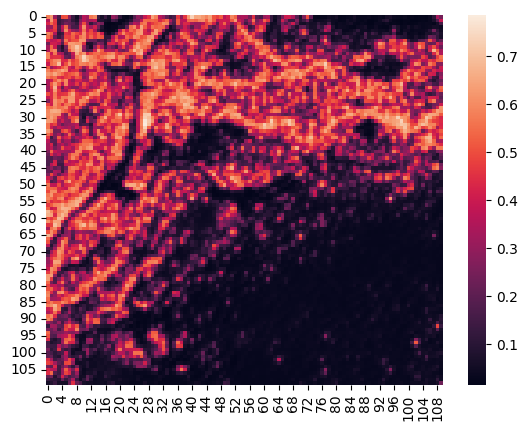

In [50]:
sns.heatmap(out.squeeze())

In [ ]:
out = sess.run(up3out, #
          feed_dict={inp: x[np.newaxis],
                     length: np.full((1,), 4),
                     labels: np.ones((1, 110, 110)),
                     mask: mask_batch,
                     is_training: True,
                     loss_weight: 1.,
                     keep_rate: 1.,
                     alpha: al,
                     beta_: be,
                     ft_lr: ft_learning_rate,
                     }).squeeze()
print(np.mean(out))
sns.heatmap(out[..., 0])

In [ ]:
out = sess.run(up3out, #
          feed_dict={inp: x[np.newaxis],
                     length: np.full((1,), 4),
                     labels: np.ones((1, 110, 110)),
                     mask: mask_batch,
                     is_training: True,
                     loss_weight: 1.,
                     keep_rate: 1.,
                     alpha: al,
                     beta_: be,
                     ft_lr: ft_learning_rate,
                     }).squeeze()
print(out.shape)
sns.heatmap(out[..., 22])

### np.sum(out[..., 0])

In [ ]:
out = sess.run(fm, #
          feed_dict={inp: x[np.newaxis],
                     length: np.full((1,), 4),
                     labels: np.ones((1, 110, 110)),
                     mask: mask_batch,
                     is_training: False,
                     loss_weight: 1.,
                     keep_rate: 0.1,
                     alpha: al,
                     beta_: be,
                     ft_lr: ft_learning_rate,
                     })
print(np.mean(out))
sns.heatmap(out.squeeze(), vmax = 1., vmin = 0.)

In [ ]:
out = sess.run(fm, #
          feed_dict={inp: x[np.newaxis],
                     length: np.full((1,), 4),
                     labels: np.ones((1, 46, 46)),
                     mask: mask_batch,
                     is_training: False,
                     loss_weight: 1.,
                     keep_rate: 0.16,
                     alpha: al,
                     beta_: be,
                     ft_lr: ft_learning_rate,
                     })
print(np.mean(out))
sns.heatmap(out.squeeze(), vmax = 1., vmin = 0.)

In [ ]:
sns.distplot(out.squeeze().flatten())

In [ ]:
np.max(out.squeeze())

In [ ]:
saver = tf.train.Saver(max_to_keep = 150)
save_path = saver.save(sess, f"../models/tf2/model")


In [ ]:

output_node_names = ['conv2d/Sigmoid']
frozen_graph_def = tf.graph_util.convert_variables_to_constants(
    sess,
    sess.graph_def,
    output_node_names)


# Save the frozen graph
with open('../models/tmp/predict_graph-8.pb', 'wb') as f:
    f.write(frozen_graph_def.SerializeToString())